In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz

import numpy as np
import torch as th
from torch_geometric.loader import DenseDataLoader
import matplotlib.pyplot as plt
from pyg_classifier.data import CGDataset
import torch_geometric as pyg


print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 3

#Training Set
import torch_geometric.transforms as T
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt"
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

Pytorch Version 1.10.2
Cuda is available: True
Using device: cuda


Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


TODO:
*  **Use A-Minor Interactions as an additional edge for graph construction DONE**
*  are there additional tertiary interactions?
*  **Integrate (Root) Mean Squared Error, Mean Absolute Error or other Regression Related Metric** 
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  add link prediction loss and entropy regularization to the loss function? if yes how?
*  which noramlization to use?

In [2]:
#Dense/Diffpool Model
import torch.nn.functional as F
import torch_geometric.nn as tgnn
import math

class GNN(th.nn.Module):
    def __init__(self, in_c, hidden_c, out_c):
        self.in_c = in_c
        self.hidden_c = hidden_c
        self.out_c = out_c
        super(GNN, self).__init__()

        self.conv = th.nn.ModuleList()
        self.norm = th.nn.ModuleList()

        self.conv.append(tgnn.DenseGraphConv(self.in_c, self.hidden_c)) #DenseGCNConv
        self.norm.append(tgnn.LayerNorm(self.hidden_c)) #BatchNorm1d(self.hidden_c)) #tgnn.GraphNorm(self.hidden_c))# tgnn or th.nn layernorm??

        self.conv.append(tgnn.DenseGraphConv(self.hidden_c, self.hidden_c))
        self.norm.append(tgnn.LayerNorm(self.hidden_c)) #BatchNorm1d(self.hidden_c)) #tgnn.GraphNorm(self.hidden_c))#

        self.conv.append(tgnn.DenseGraphConv(self.hidden_c, self.out_c))
        self.norm.append(tgnn.LayerNorm(self.out_c)) #BatchNorm1d(self.out_c)) #tgnn.GraphNorm(self.out_c))#

    def forward(self, x, adj, mask=None):
        for step in range(len(self.conv)):
            x = self.conv[step](x, adj, mask)
            x = F.elu(self.norm[step](x))
        
        return x


#Coarse Grain RNA Classifier Model
class Diff_CG_Classifier(th.nn.Module):
    def __init__(self, num_node_feats):
        self.num_node_feats = num_node_feats
        super(Diff_CG_Classifier, self).__init__()

        num_nodes = math.ceil(0.25 * 64)
        self.gcn_pool1 = GNN(self.num_node_feats, 64, num_nodes)
        self.gcn_embed1 = GNN(self.num_node_feats, 64, 64)

        num_nodes = math.ceil(0.25 * num_nodes)
        self.gcn_pool2 = GNN(64, 64, num_nodes)
        self.gcn_embed2 = GNN(64, 64, 64)

        num_nodes = math.ceil(0.25 * num_nodes)
        self.gcn_pool3 = GNN(64, 64, num_nodes)
        self.gcn_embed3 = GNN(64, 64, 64)

        self.gcn_embed4 = GNN(64, 64, 64)
        
        self.classify = th.nn.Sequential(
            th.nn.Linear(64, 256),# 512),
            th.nn.ELU(),
            th.nn.Linear(256, 256), #(512, 512),
            th.nn.ELU(),
            th.nn.Linear(256, 256), #(512, 512),
            th.nn.ELU(),
            th.nn.Linear(256, 256), #(512, 512),
            th.nn.ELU(),
            th.nn.Linear(256, 1) #(512, 1)
        )
        self.pos = th.nn.ReLU()#th.nn.Softplus(threshold=1)

    def forward(self, data, training=False):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch
        adj = data.adj

        s = self.gcn_pool1(x, adj)
        x = self.gcn_embed1(x, adj)

        x, adj, l1, e1 = tgnn.dense_diff_pool(x, adj, s)
        l = l1
        e = e1

        s = self.gcn_pool2(x, adj)
        x = self.gcn_embed2(x, adj)

        x, adj, l2, e2 = tgnn.dense_diff_pool(x, adj, s)
        l+=l2
        e+=e2

        s = self.gcn_pool3(x, adj)
        x = self.gcn_embed3(x, adj)

        x, adj, l3, e3 = tgnn.dense_diff_pool(x, adj, s)
        l+=l3
        e+=e3

        x = self.gcn_embed4(x, adj)

        #x = tgnn.global_mean_pool(x, batch)
        x = x.mean(dim=1)

        x = self.classify(x)
        
        #return x, l, e

        if training:
            return x, l, e
        else:
            return self.pos(x), l, e

Epoch 0: Training loss 16.2231, Validation loss 19.0290, learning rate 0.00100
	 Validation MAE: 15.6149
Epoch 5: Training loss 8.6086, Validation loss 18.8177, learning rate 0.00100
	 Validation MAE: 15.4537
Epoch 10: Training loss 8.0489, Validation loss 18.7698, learning rate 0.00100
	 Validation MAE: 15.4211
Epoch 15: Training loss 7.8650, Validation loss 19.0747, learning rate 0.00100
	 Validation MAE: 15.7377
Epoch 20: Training loss 7.2764, Validation loss 19.0837, learning rate 0.00100
	 Validation MAE: 15.8201
Epoch 25: Training loss 6.0805, Validation loss 17.8011, learning rate 0.00100
	 Validation MAE: 15.9590
Epoch 30: Training loss 5.1801, Validation loss 17.8233, learning rate 0.00100
	 Validation MAE: 16.2211
Epoch 35: Training loss 4.9665, Validation loss 17.4667, learning rate 0.00100
	 Validation MAE: 15.9547
Epoch 40: Training loss 4.7845, Validation loss 17.0392, learning rate 0.00100
	 Validation MAE: 15.5776
Epoch 45: Training loss 4.4194, Validation loss 16.8791,

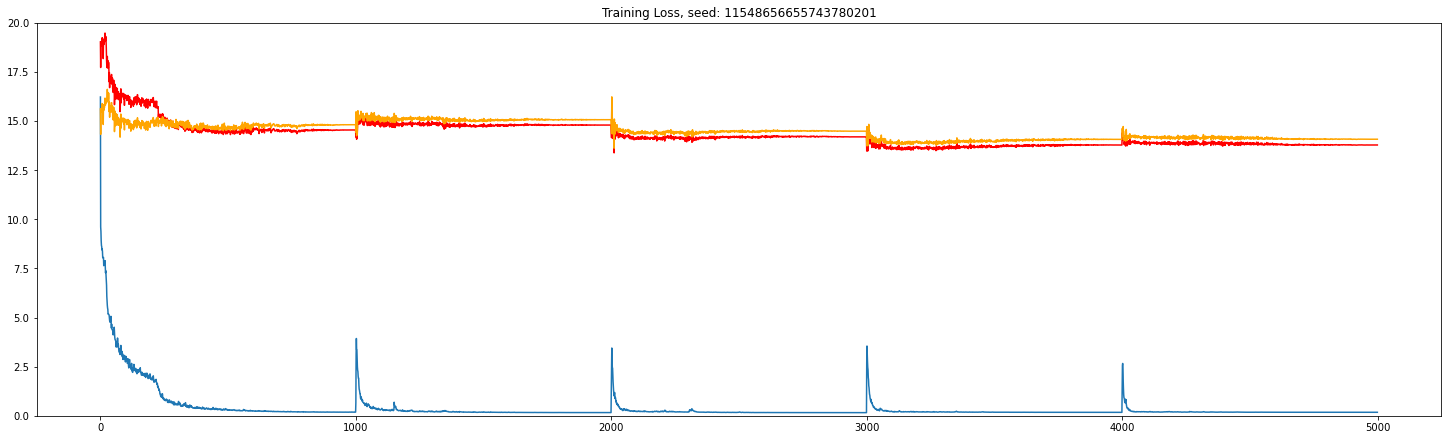

In [3]:
#Training
import time
import math
start = time.perf_counter()

num_node_feats = training_dataset.num_node_features

seed = 11548656655743780201
th.manual_seed(seed)
th.cuda.manual_seed(seed)
#pyg.seed_everything(seed)
    
model = Diff_CG_Classifier(num_node_feats).to(device)

b_size = 64
train_dataloader = DenseDataLoader(training_dataset, batch_size=b_size, shuffle=True)
val_dataloader = DenseDataLoader(val_dataset, batch_size=b_size)

opt = th.optim.Adam(model.parameters(), lr=1e-3)
scheduler = th.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=1000)
model.train()

epochs = 5000
'''
def training_loop(model, learning_rates, train_dataloader, scheduler, opt):
    model.train()
    epoch_loss = 0
    learning_rates.append(scheduler.get_last_lr()[0])
    for iter, data in enumerate(train_dataloader):
        data = data.to(device)
        opt.zero_grad()
        pred, l, e = model(data, model.training)
        loss = F.smooth_l1_loss(pred, data.y, reduction='mean')
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()

    #apply lr changes according to scheme
    scheduler.step()

    epoch_loss /= (iter + 1)
    return epoch_loss, l, e
'''
@th.no_grad()
def val_loop(model, val_dataloader):
    model.eval()
    val_loss = 0
    mae_loss = 0
    for i, v_data in enumerate(val_dataloader):
        v_data = v_data.to(device)
        val_pred, vl, ve = model(v_data)
        v_loss = F.smooth_l1_loss(val_pred, v_data.y, reduction="mean") + vl + ve
        mae_l= F.l1_loss(val_pred, v_data.y, reduction="mean")
        mae_loss += mae_l.detach().item()
        val_loss += v_loss.detach().item()

    val_loss /= (i + 1)
    mae_loss /= (i + 1)
    return val_loss, mae_loss

#training setup
epoch_losses = []
val_losses = []
mae_losses = []
learning_rates = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    learning_rates.append(scheduler.get_last_lr()[0])
    for iter, data in enumerate(train_dataloader):
        data = data.to(device)
        opt.zero_grad()
        pred, l, e = model(data, model.training)
        loss = F.smooth_l1_loss(pred, data.y, reduction="mean")
        final_loss = loss + l + e #trying out simple combination
        final_loss.backward()
        opt.step()
        epoch_loss += final_loss.detach().item() #loss.detach().item()

    #apply lr changes according to scheme
    scheduler.step()

    epoch_loss /= (iter + 1)
    #epoch_loss, l, e = training_loop(model, learning_rates, train_dataloader, scheduler, opt)
    epoch_losses.append(epoch_loss)

    #val setup
    val_loss, mae_loss = val_loop(model, val_dataloader)
    val_losses.append(val_loss)
    mae_losses.append(mae_loss)

    th.save(model.state_dict(), "pyg_diff_model_data/model_epoch" + str(epoch) + ".pth")
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Training loss {epoch_loss:.4f}, Validation loss {val_loss:.4f}, learning rate {scheduler.get_last_lr()[0]:.5f}")
        print(f"\t Validation MAE: {mae_loss:.4f}")
        
end = time.perf_counter()

print(f"Training took {(end - start)/60/60:.2f} hours")
print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after 50 epochs) {min(val_losses[50:]):.4f} in epoch {val_losses.index(min(val_losses[50:]))}")
print(f"Minimum MAE (after 50 epochs) {min(mae_losses[50:]):.4f} in epoch {mae_losses.index(min(mae_losses[50:]))}")
print(f"Seed used for training was: {th.initial_seed()}")

#plot the training run
figure, ax = plt.subplots(layout="constrained", figsize=(20, 6))
ax.plot(epoch_losses)
ax.plot(val_losses, "r")
ax.plot(mae_losses, "orange")
plt.title(f"Training Loss, seed: {th.initial_seed()}")
ax.set_ybound(lower=0, upper=20)
plt.draw()

In [4]:
#store training run data

file = "pyg_loss_b64_vec-k3-diff_loss_data_2022-04-01.txt"

with open("loss_data/" + file, "w") as fh:
    fh.write(str(epoch_losses) + "\n")
    fh.write(str(val_losses) + "\n")
    fh.write(str(learning_rates) + "\n")
    fh.write(str(mae_losses))

In [3]:
#get training run data

file = "pyg_relu-vec-k3-diff_loss_data_2022-03-28.txt"

file_lines = []
with open("loss_data/" + file, "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after 50 epochs) {min(val_losses[50:]):.4f} in epoch {val_losses.index(min(val_losses[50:]))}")
print(f"Minimum MAE (after 50 epochs) {min(mae_losses[50:]):.4f} in epoch {mae_losses.index(min(mae_losses[50:]))}")


Minimum Training Loss 0.0000 in epoch 4498
Minimum Validation Loss (after 50 epochs) 12.4665 in epoch 1505


Validation Loss at 3800 is 13.7756
MAE at 3800 is 14.0621


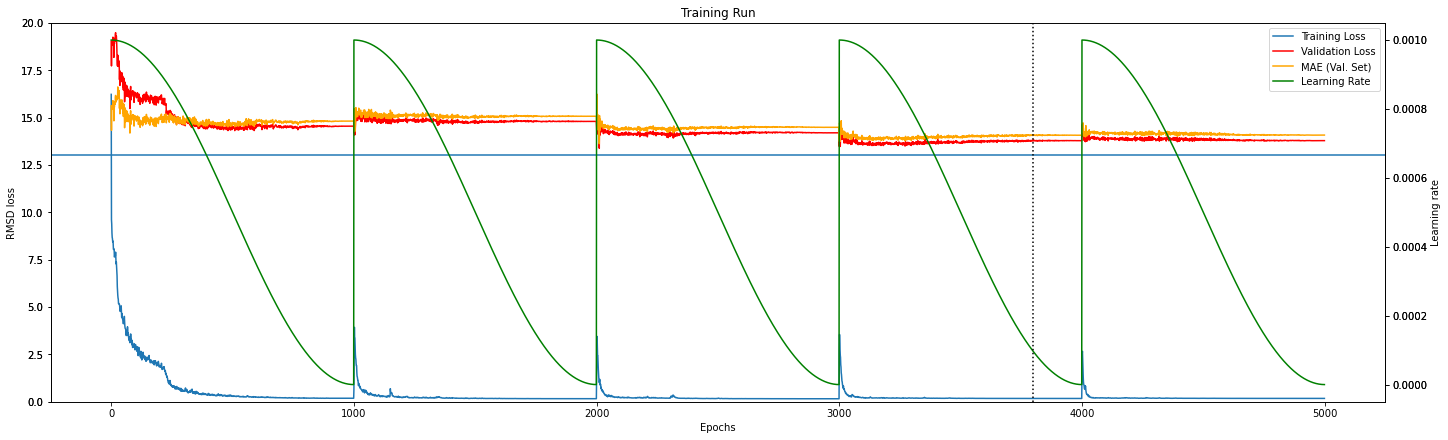

In [27]:
#plot the training run
select = 3800
print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")
ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("RMSD loss")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=0, upper=20)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=13)
han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2)
plt.draw()

In [7]:
#Test Loop
import math
from pyg_classifier.utility import loss_plot, rmsd_scatter, e_rmsd_scatter

@th.no_grad()
def test_loop(model, loader, e_dict, title):
    model.eval()
    max_label = 0
    max_loss = 0
    max_pred = 0
    min_label = math.inf
    min_loss = math.inf
    min_pred = math.inf
    test_losses = []
    true_rmsds = []
    pred_rmsds = []
    energies = []
    trmsds_f_en = []
    prmsds_f_en = []
    for test_graph in loader:
        test_graph = test_graph.to(device)
        test_pred, _, _ = model(test_graph)
        test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item() # l1_loss(th.reshape(test_pred, (-1,)), test_graph.y).item() #
        test_losses.append(float(test_loss))
        true_rmsds.append(float(test_graph.y))
        pred_rmsds.append(float(test_pred))

        if test_graph.name[0] in e_dict.keys():
            energies.append(e_dict[test_graph.name[0]])
            prmsds_f_en.append(float(test_pred))
            trmsds_f_en.append(float(test_graph.y))
        if test_loss > max_loss:
            max_loss = test_loss
            max_label = test_graph.y
            max_pred = test_pred
        if test_loss < min_loss:
            min_loss = test_loss
            min_label = test_graph.y
            min_pred = test_pred
        if test_pred < 0:
            print(test_graph.y, test_pred)
    
    print(title)
    print(min_label, min_pred, min_loss)
    print(max_label, max_pred, max_loss)
    test_mean = np.mean(test_losses)
    test_std = np.std(test_losses)
    test_fq = np.quantile(test_losses, q = 0.25)
    test_median = np.median(test_losses)
    test_tq = np.quantile(test_losses, q = 0.75)
    print("Mean Test loss: \t {:.4f}".format(test_mean))
    print("Std. Dev. of Test loss:  {:.4f}".format(test_std))
    print("Min loss: \t\t {:.4f}".format(min(test_losses)))
    print("First Quantile: \t {:.4f}".format(test_fq))
    print("Median: \t\t {:.4f}".format(test_median))
    print("Third Quantile: \t {:.4f}".format(test_tq))
    print("Max Loss: \t\t {:.4f}".format(max(test_losses)))
    
    loss_plot(test_losses, test_fq, test_median, test_tq, title + ", Sorted Test Losses")
    rmsd_scatter(pred_rmsds, true_rmsds, title)
    e_rmsd_scatter(energies, trmsds_f_en, title + ", True RMSDs vs Energy")
    e_rmsd_scatter(energies, prmsds_f_en, title + ", Predicted RMSDs vs Energy")
    return energies, trmsds_f_en, prmsds_f_en

Test Set
tensor([[26.3880]], device='cuda:0') tensor([[26.4319]], device='cuda:0') 0.0009634171728976071
tensor([[0.]], device='cuda:0') tensor([[35.2762]], device='cuda:0') 34.776161193847656
Mean Test loss: 	 11.9689
Std. Dev. of Test loss:  8.2063
Min loss: 		 0.0010
First Quantile: 	 5.2328
Median: 		 10.5910
Third Quantile: 	 19.2684
Max Loss: 		 34.7762


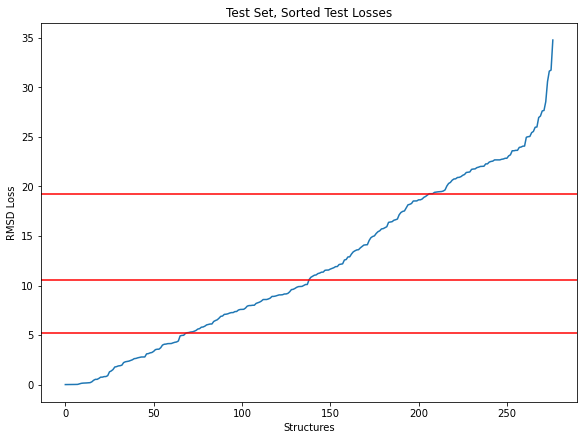

LinregressResult(slope=0.084364782107114, intercept=15.031584934577818, rvalue=0.049412199770226074, pvalue=0.41269252263814427, stderr=0.10283236549917889, intercept_stderr=2.3018813604796278)


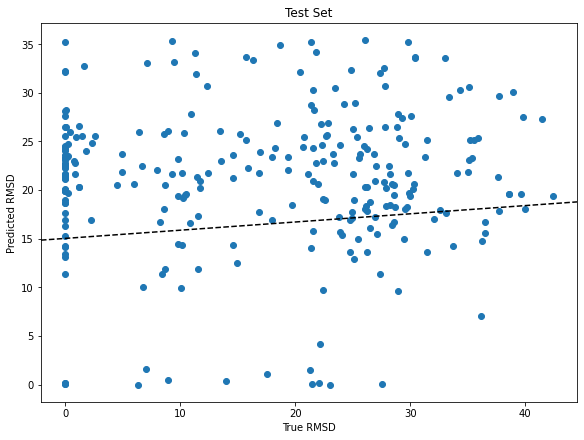

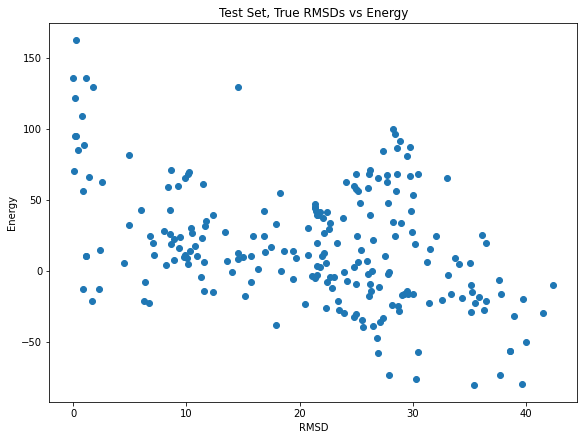

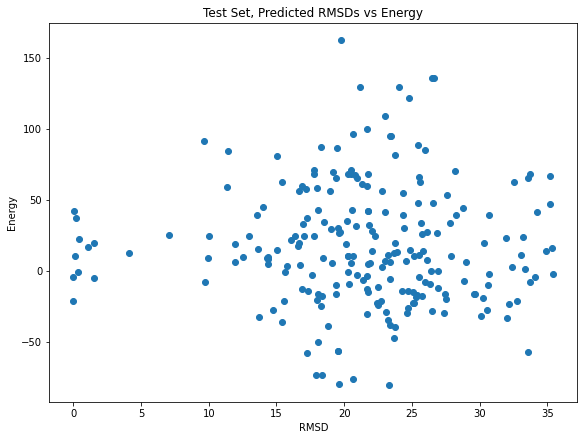

5S and tRNA Test Set
tensor([[18.6330]], device='cuda:0') tensor([[18.6395]], device='cuda:0') 2.131296969309915e-05
tensor([[0.]], device='cuda:0') tensor([[30.2919]], device='cuda:0') 29.7918758392334
Mean Test loss: 	 5.2337
Std. Dev. of Test loss:  6.0640
Min loss: 		 0.0000
First Quantile: 	 0.9476
Median: 		 2.9998
Third Quantile: 	 7.0924
Max Loss: 		 29.7919


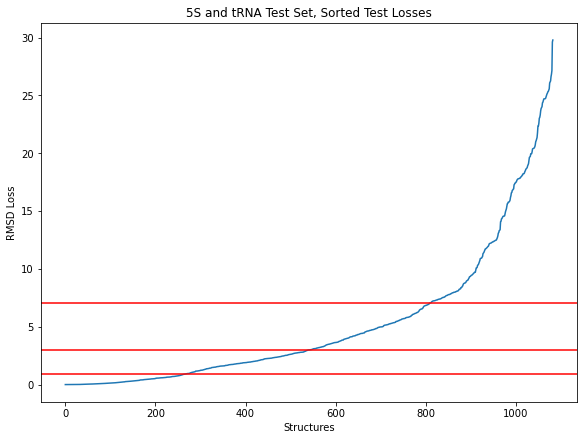

LinregressResult(slope=0.6537097027328368, intercept=3.69915652071084, rvalue=0.5546219907050138, pvalue=2.2446040953244154e-88, stderr=0.029829899280883972, intercept_stderr=0.6005588735427605)


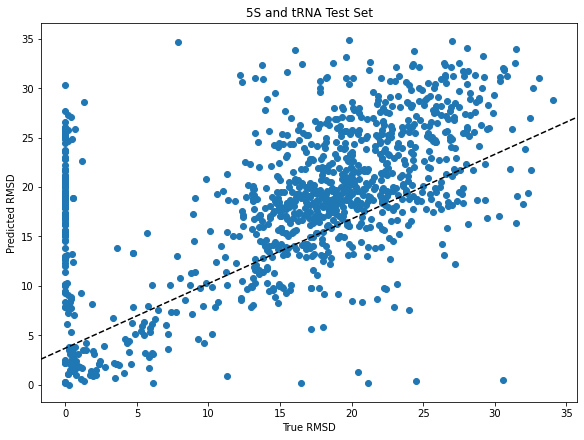

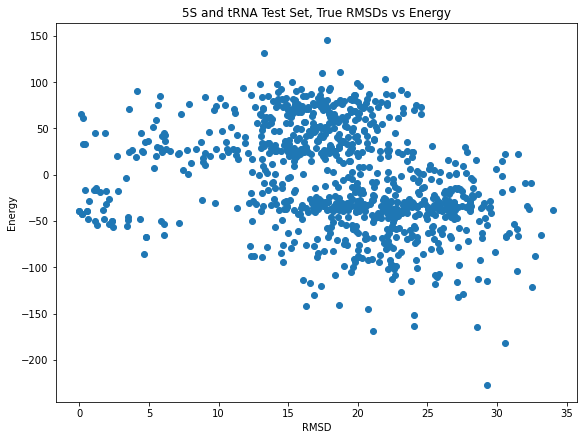

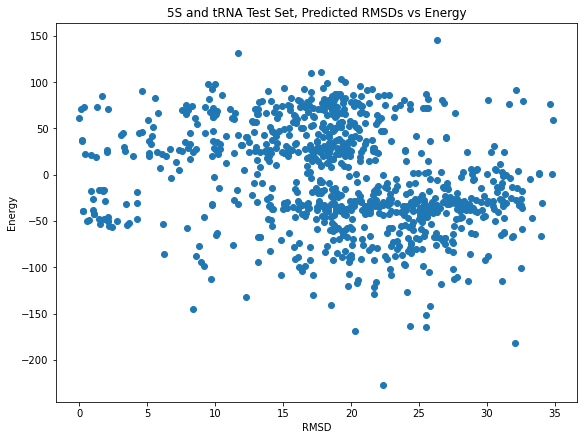

Training Set
tensor([[19.7480]], device='cuda:0') tensor([[19.7487]], device='cuda:0') 2.35741026699543e-07
tensor([[14.9370]], device='cuda:0') tensor([[17.8117]], device='cuda:0') 2.3746776580810547
Mean Test loss: 	 0.2397
Std. Dev. of Test loss:  0.3675
Min loss: 		 0.0000
First Quantile: 	 0.0141
Median: 		 0.0748
Third Quantile: 	 0.3056
Max Loss: 		 2.3747


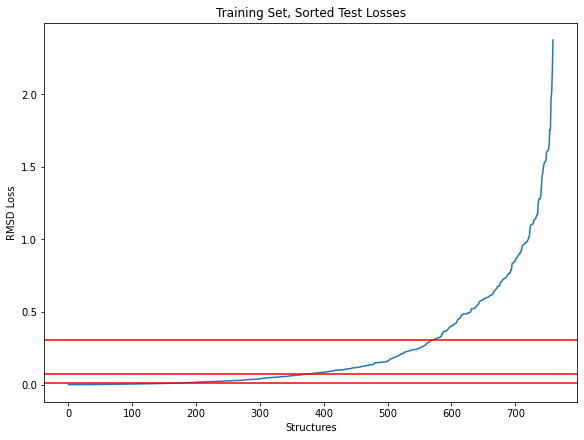

LinregressResult(slope=0.9789685255227287, intercept=0.1843640037810843, rvalue=0.9972763096496112, pvalue=0.0, stderr=0.002629762725435926, intercept_stderr=0.05356431907399579)


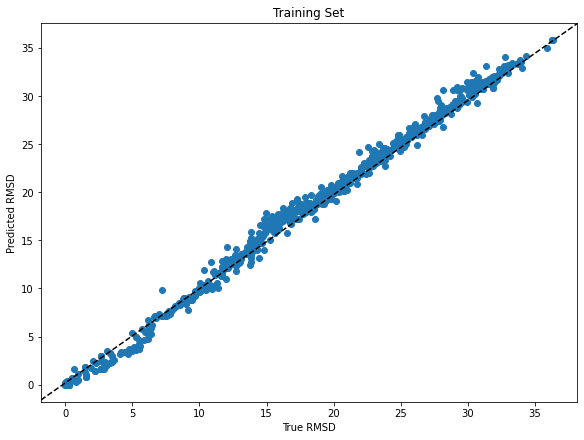

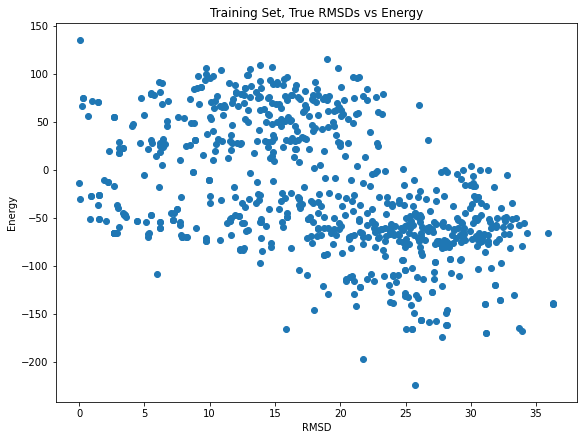

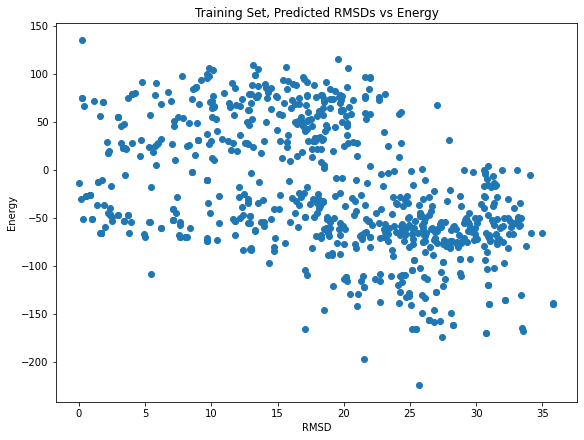

Validation Set
tensor([[19.6930]], device='cuda:0') tensor([[19.6610]], device='cuda:0') 0.0005118647823110223
tensor([[61.9850]], device='cuda:0') tensor([[14.0207]], device='cuda:0') 47.464332580566406
Mean Test loss: 	 13.6905
Std. Dev. of Test loss:  10.0208
Min loss: 		 0.0005
First Quantile: 	 5.2510
Median: 		 12.4588
Third Quantile: 	 21.1854
Max Loss: 		 47.4643


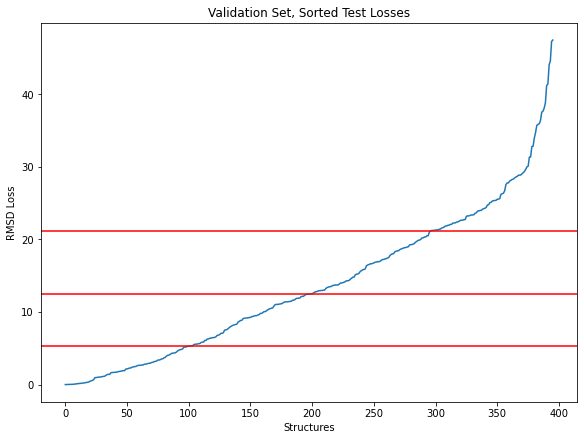

LinregressResult(slope=-0.05515497557588136, intercept=24.45180118787297, rvalue=-0.02128688946636687, pvalue=0.6727969139619203, stderr=0.13050464272319595, intercept_stderr=2.967007405648317)


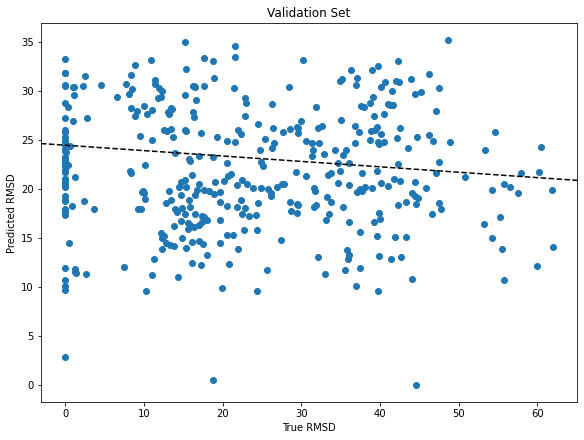

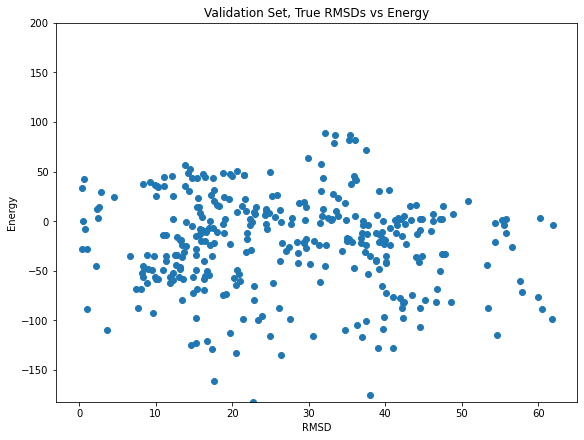

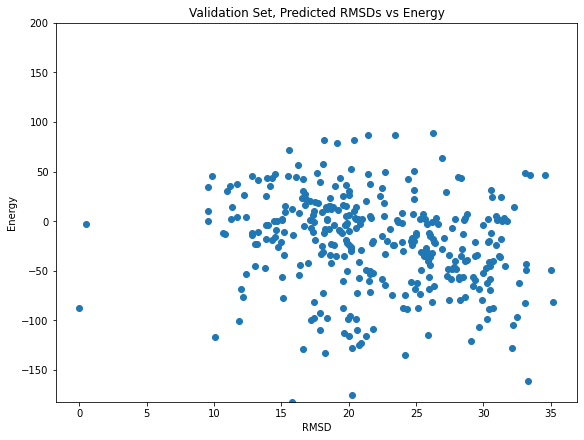

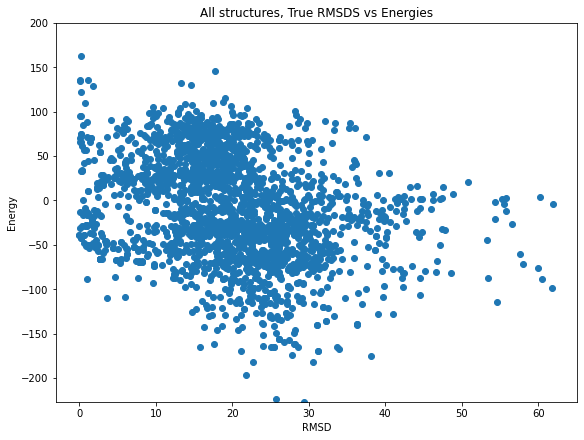

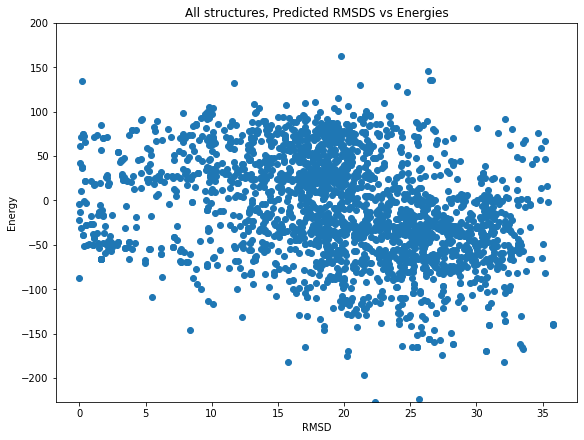

In [28]:
#Test
import math
from pyg_classifier.utility import get_energy_dict

if "model" not in globals():
    num_node_feats = training_dataset.num_node_features
    model = Diff_CG_Classifier(num_node_feats).to(device)

train_loader = DenseDataLoader(training_dataset, batch_size=1)
val_loader = DenseDataLoader(val_dataset, batch_size=1)
test_dataloader = DenseDataLoader(test_dataset, batch_size=1)
st_test_dataloader = DenseDataLoader(st_test_dataset, batch_size=1)

model.to(device)
model.load_state_dict(th.load("pyg_diff_model_data/model_epoch3800.pth"))

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs = test_loop(model, loader, e_dict, title)
    energy_l += en
    true_rmsd_l += trs
    pred_rmsd_l += prs

e_rmsd_scatter(energy_l, true_rmsd_l, "All structures, True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures, Predicted RMSDS vs Energies")

In [9]:
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k, transform=T.ToDense(64))

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = CGDataset(fst_test_rot, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

Processing...
Done!
Processing...
Done!


LinregressResult(slope=0.07448083685669664, intercept=18.836154939313698, rvalue=0.09943066969487438, pvalue=0.09864311143291095, stderr=0.04494696134834714, intercept_stderr=1.006128489174789)


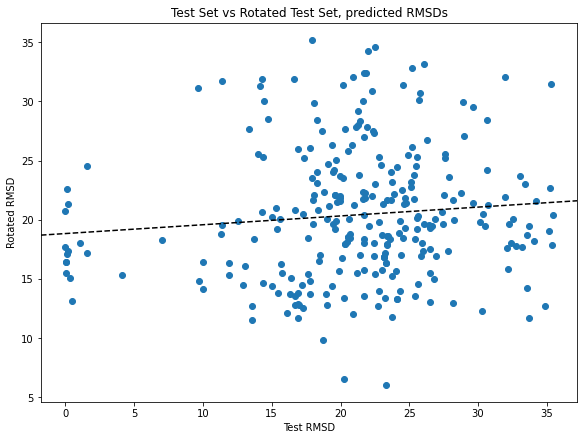

LinregressResult(slope=0.5050427343965319, intercept=5.6006428242213, rvalue=0.5372432650864013, pvalue=4.083529686721808e-22, stderr=0.04781217214453939, intercept_stderr=0.6938488216067562)


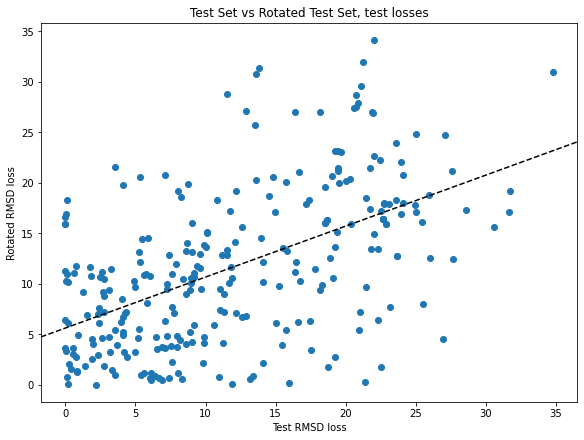

LinregressResult(slope=0.20305275833614758, intercept=15.592524022532903, rvalue=0.33138141109347935, pvalue=3.596269242785792e-29, stderr=0.017583623309883337, intercept_stderr=0.35400726326122645)


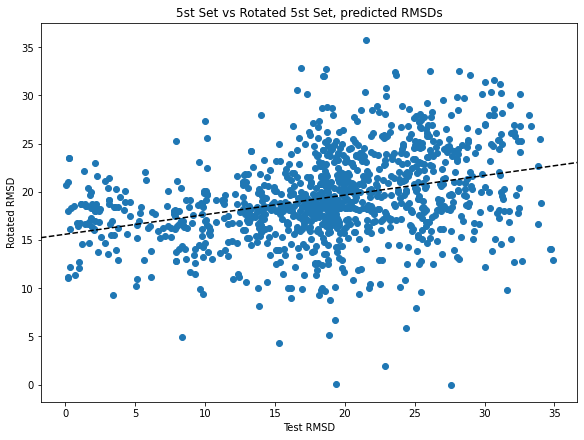

LinregressResult(slope=0.5819340344123084, intercept=3.4814538445571452, rvalue=0.5395369820211375, pvalue=7.817408766676537e-83, stderr=0.02762053796406693, intercept_stderr=0.221247010426226)


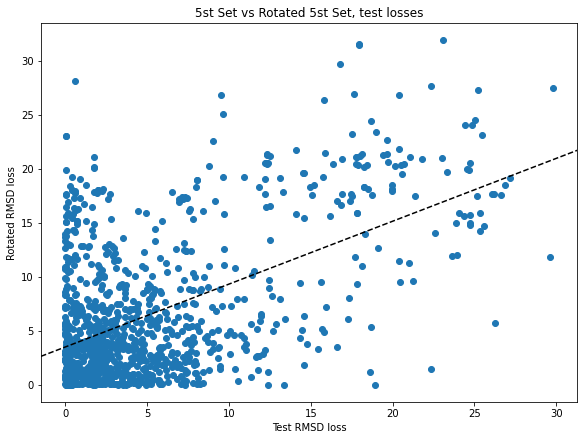

In [30]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DenseDataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DenseDataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")